In [1]:
import pandas as pd
import numpy as np

### Sources 
1 - http://blog.yhat.com/posts/the-beer-bandit.html  
2 - https://github.com/bgalbraith/bandits  
3 - https://towardsdatascience.com/solving-the-multi-armed-bandit-problem-b72de40db97c
4 - http://nbviewer.jupyter.org/gist/glamp/20a18d52c539b87de2af

### Notes

- Maximize profit (reduce regret) by testing different levels and remembering the rewards
- Bandit algorithms are automated to move away from low scoring options and inherently prefer those that preform better
- Two possibilities when choosing options: exploit or explore  

    1) **Explore** --> testing, reduce uncertainty  
    2) **Exploit** --> choose the best option, go for the mean 


Rewards -- Should define what reward is? Clicks/page views!

**Epsilon Greedy** --> epsilon = test, (1-epsilon) = exploit (best arm)

## Epsilon Greedy Class

In [11]:
np.random.random()

0.24574510341135025

In [12]:
np.random.randint(low =0, high = 10)

5

In [13]:
values = [9,22,3,4,0,0]

In [14]:
np.argmax(values)

1

In [15]:
class EpsilonGreedy(object):
    def __init__(self, n, epsilon_decay = 50):
        self.counts = [0]*n # e.g. number of views
        self.values = [0.]*n # e.g. number of clicks/views
        self.decay = epsilon_decay
        self.n = n
    
    def get_epsilon(self):
        """Produce new epsilon"""
        total = np.sum(self.counts)
        return float(self.decay)/(total + float(self.decay))
    
    def choose_arm(self):
        """Choose arm for testing"""
        epsilon = self.get_epsilon()
        print(epsilon)
        if np.random.random() > epsilon:
            ## Exploit --> choose best arm
            print("Going for EXPLOIT")
            return np.argmax(self.values)
        else:
            ## Explore --> test other options
            print("Going for EXPLORE")
            return np.random.randint(self.n)
        
    def update(self, arm, reward):
        """Update arm with reward value --> click = 1, no_click = 0""" 
        print("Counts before {}".format(self.counts[arm]))
        self.counts[arm] =  self.counts[arm] + 1
        print("Counts after {}".format(self.counts[arm]))

        n = self.counts[arm]
        print("n value - {}".format(n))
        value = self.values[arm]
        
        ## Running product
        new_value = ((n-1)/float(n))*value + (1/float(n))*reward
        print("New Value {}".format(new_value))
        self.values[arm] = new_value


In [ ]:
recommender = EpsilonGreedy(n=5)

In [ ]:
arm = recommender.choose_arm()
print("ARM CHOOSEN: {}".format(arm))
recommender.update(arm,reward=0.5)
print("VALUES: {}".format(recommender.values))
print("COUNTS: {}".format(recommender.counts))

In [ ]:
print(np.argmax(recommender.values))

In [ ]:
!ls beer_reviews

In [ ]:
df = pd.read_csv("beer_reviews/beer_reviews.csv")

In [ ]:
df.tail(5)

In [ ]:
print(len(set(df['review_profilename'])))

In [ ]:
top_n = df.beer_name.value_counts().index[:100]
top_n

In [ ]:
print(len(set(df.beer_name)))

In [ ]:
df = df[df.beer_name.isin(top_n)].reset_index(drop=True)

In [ ]:
print(len(set(df.beer_name)))

In [ ]:
df.tail(5)

In [ ]:
df_wide = pd.pivot_table(df, values=["review_overall"],
        columns=["beer_name", "review_profilename"],
        aggfunc=np.mean).unstack()
df_wide = df_wide.fillna(0)

In [ ]:

print(len(df_wide.columns))

In [ ]:
from sklearn.metrics.pairwise import (
    euclidean_distances, cosine_similarity, pairwise_distances
)

In [ ]:
eucl_dists = euclidean_distances(df_wide)
eucl_dists = pd.DataFrame(eucl_dists, columns=df_wide.index)
eucl_dists.index = eucl_dists.columns

In [ ]:
eucl_dists

In [ ]:
# Calculate cosine similarity
cos_dists = cosine_similarity(df_wide)
cos_dists = pd.DataFrame(cos_dists, columns=df_wide.index)
cos_dists.index = cos_dists.columns

In [ ]:
cos_dists

In [ ]:
# Calculate distance correlation
corr_dists = pairwise_distances(df_wide,metric='correlation')
corr_dists = pd.DataFrame(corr_dists, columns=df_wide.index)
corr_dists.index = corr_dists.columns

In [ ]:
corr_dists

In [ ]:
def get_sims(products, dists, larger_is_closer=False):
    """Return similarity matrix"""
    p = dists.review_overall[products].apply(lambda row: np.sum(row), axis=1)
    p = p.order(ascending=larger_is_closer)
    return p.index[p.index.isin(products)==False]

In [ ]:
products = ["Sierra Nevada Pale Ale", "120 Minute IPA", "60 Minute IPA"]

In [ ]:
eucl_dists.review_overall['Sierra Nevada Pale Ale']

## Other Algorithms

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
bandit_probs = [0.10, 0.82, 0.60, 0.75, 0.10,
                0.25, 0.60, 0.45, 0.75, 0.65]  # bandit probabilities of success
N_experiments = 2000  # number of experiments to perform
N_episodes = 10000  # number of episodes per experiment
epsilon = 0.5  # probability of random exploration (fraction)
save_fig = True  # if false -> plot, if true save as file in same directory
save_format = ".png"  # ".pdf" or ".png"

In [3]:
class Bandit:
    def __init__(self, bandit_probs):
        self.N = len(bandit_probs)  # number of bandits
        self.prob = bandit_probs  # success probabilities for each bandit

    # Get reward (1 for success, 0 for failure)
    def get_reward(self, action):
        rand = np.random.random()  # [0.0,1.0)
        reward = 1 if (rand < self.prob[action]) else 0
        return reward

In [4]:
class Agent:
    def __init__(self, bandit, epsilon):
        self.epsilon = epsilon
        self.k = np.zeros(bandit.N, dtype=np.int)  # number of times action was chosen
        self.Q = np.zeros(bandit.N, dtype=np.float)  # estimated value

    # Update Q action-value using:
    # Q(a) <- Q(a) + 1/(k+1) * (r(a) - Q(a))
    def update_Q(self, action, reward):
        self.k[action] += 1  # update action counter k -> k+1
        self.Q[action] += (1./self.k[action]) * (reward - self.Q[action])

    # Choose action using an epsilon-greedy agent
    def choose_action(self, bandit, force_explore=False):
        rand = np.random.random()  # [0.0,1.0)
        if (rand < self.epsilon) or force_explore:
            action_explore = np.random.randint(bandit.N)  # explore random bandit
            return action_explore
        else:
            #action_greedy = np.argmax(self.Q)  # exploit best current bandit
            action_greedy = np.random.choice(np.flatnonzero(self.Q == self.Q.max()))
            return action_greedy

In [5]:
def experiment(agent, bandit, N_episodes):
    action_history = []
    reward_history = []
    for episode in range(N_episodes):
        # Choose action from agent (from current Q estimate)
        action = agent.choose_action(bandit)
        # Pick up reward from bandit for chosen action
        reward = bandit.get_reward(action)
        # Update Q action-value estimates
        agent.update_Q(action, reward)
        # Append to history
        action_history.append(action)
        reward_history.append(reward)
    return (np.array(action_history), np.array(reward_history))

In [6]:
N_bandits = len(bandit_probs)
N_bandits

10

In [7]:
reward_history_avg = np.zeros(N_episodes)  # reward history experiment-averaged
action_history_sum = np.zeros((N_episodes, N_bandits))  # sum action history

In [8]:
for i in range(N_experiments):
    bandit = Bandit(bandit_probs)  # initialize bandits
    agent = Agent(bandit, epsilon)  # initialize agent
    (action_history, reward_history) = experiment(agent, bandit, N_episodes)  # perform experiment

    if (i + 1) % (N_experiments / 20) == 0:
        print("[Experiment {}/{}]".format(i + 1, N_experiments))
        print("  N_episodes = {}".format(N_episodes))
        print("  bandit choice history = {}".format(
            action_history + 1))
        print("  reward history = {}".format(
            reward_history))
        print("  average reward = {}".format(np.sum(reward_history) / len(reward_history)))
        print("")
    # Sum up experiment reward (later to be divided to represent an average)
    reward_history_avg += reward_history
    # Sum up action history
    for j, (a) in enumerate(action_history):
        action_history_sum[j][a] += 1

reward_history_avg /= np.float(N_experiments)
print("reward history avg = {}".format(reward_history_avg))

[Experiment 100/2000]
  N_episodes = 10000
  bandit choice history = [1 8 6 ... 6 2 2]
  reward history = [0 0 0 ... 0 1 1]
  average reward = 0.6676

[Experiment 200/2000]
  N_episodes = 10000
  bandit choice history = [10  4  1 ...  3  2  2]
  reward history = [0 0 0 ... 0 1 0]
  average reward = 0.6582

[Experiment 300/2000]
  N_episodes = 10000
  bandit choice history = [4 4 4 ... 9 9 2]
  reward history = [1 1 0 ... 1 1 1]
  average reward = 0.6667

[Experiment 400/2000]
  N_episodes = 10000
  bandit choice history = [ 7  7  3 ...  2  2 10]
  reward history = [1 1 0 ... 1 1 1]
  average reward = 0.6628

[Experiment 500/2000]
  N_episodes = 10000
  bandit choice history = [1 7 6 ... 8 3 2]
  reward history = [0 1 0 ... 1 1 0]
  average reward = 0.6655

[Experiment 600/2000]
  N_episodes = 10000
  bandit choice history = [5 3 7 ... 1 2 4]
  reward history = [0 1 0 ... 0 0 1]
  average reward = 0.6555

[Experiment 700/2000]
  N_episodes = 10000
  bandit choice history = [6 6 6 ... 2 

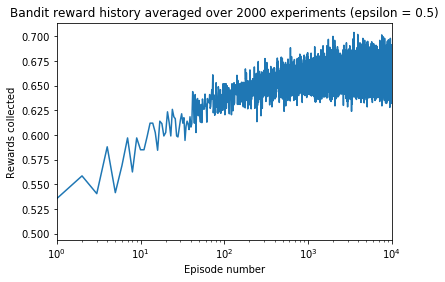

In [9]:
# =========================
# Plot reward history results
# =========================
plt.plot(reward_history_avg)
plt.xlabel("Episode number")
plt.ylabel("Rewards collected".format(N_experiments))
plt.title("Bandit reward history averaged over {} experiments (epsilon = {})".format(N_experiments, epsilon))
ax = plt.gca()
ax.set_xscale("log", nonposx='clip')
plt.xlim([1, N_episodes])
if save_fig:
    output_file = "MAB_rewards" + save_format
    plt.savefig(output_file, bbox_inches="tight")
else:
    plt.show()

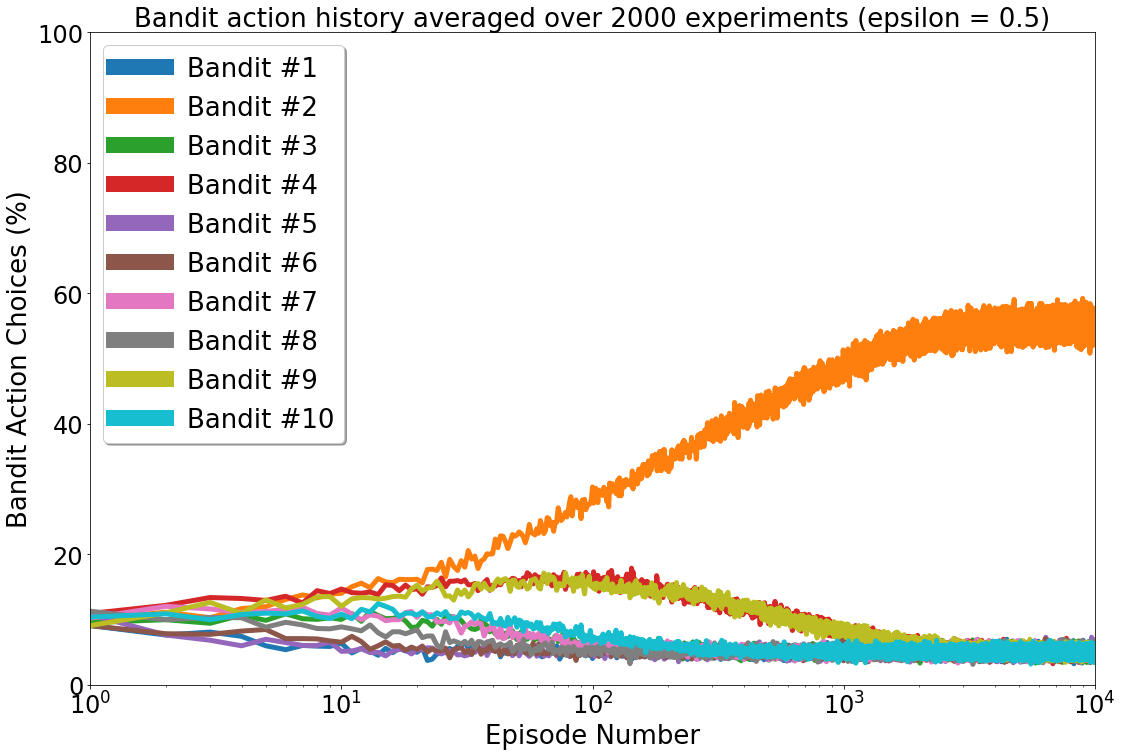

In [10]:
# =========================
# Plot action history results
# =========================
plt.figure(figsize=(18, 12))
for i in range(N_bandits):
    action_history_sum_plot = 100 * action_history_sum[:,i] / N_experiments
    plt.plot(list(np.array(range(len(action_history_sum_plot)))+1),
             action_history_sum_plot,
             linewidth=5.0,
             label="Bandit #{}".format(i+1))
plt.title("Bandit action history averaged over {} experiments (epsilon = {})".format(N_experiments, epsilon), fontsize=26)
plt.xlabel("Episode Number", fontsize=26)
plt.ylabel("Bandit Action Choices (%)", fontsize=26)
leg = plt.legend(loc='upper left', shadow=True, fontsize=26)
ax = plt.gca()
ax.set_xscale("log", nonposx='clip')
plt.xlim([1, N_episodes])
plt.ylim([0, 100])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
for legobj in leg.legendHandles:
    legobj.set_linewidth(16.0)
if save_fig:
    output_file = "MAB_actions" + save_format
    plt.savefig(output_file, bbox_inches="tight")
else:
    plt.show()

## Contextual Bandits

- News recommendation
- Reward = clock-through behavior of the user --> place the ADS of news recommendation
- Amazon - increases sales --> 21% more sales
- For us --> what is sales?
    - Time spent in viewpoint?
- Repeat
    - Learner presented with Context
    - Learner chooses an action
    - Learner observes *reward* (for chosen action)  
**GOAL** --> learn to choose actions to maximize rewards